## Detect Covid-19 with X-ray images

The dataset of this project is share by __Dr. Joseph Pau Cohen__ from University of Montreal in an attempt to predict and understand the infection. His repository where I downloaded the dataset can be found [here](https://github.com/ieee8023/covid-chestxray-dataset).

Below are some key points regarding this project:
    - The model was train in the dataset of 25 X-ray images of Covid patients and 25 X-ray images of normal patients.
    - The model uses Resnet50 as transfer learning model.
    - The accuracy of this model is 90%.
    - The result are for reference only.

### Please notice that any prediction delivered by the model is only for reference and educational purpose!

### Data Visualization

The datasets contain two categories: X-ray images of patients who were diagnosed with COVID-19 and patient who were normal. There are 25 images in each category. 

In [68]:
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
%matplotlib.line

UsageError: Line magic function `%matplotlib.line` not found.


In [61]:
# declear a function to read image using cv2 and resize them to the same size as 480x480

def image_process(image):
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb,(224,224))
    return img_resize

Found 25 covid images


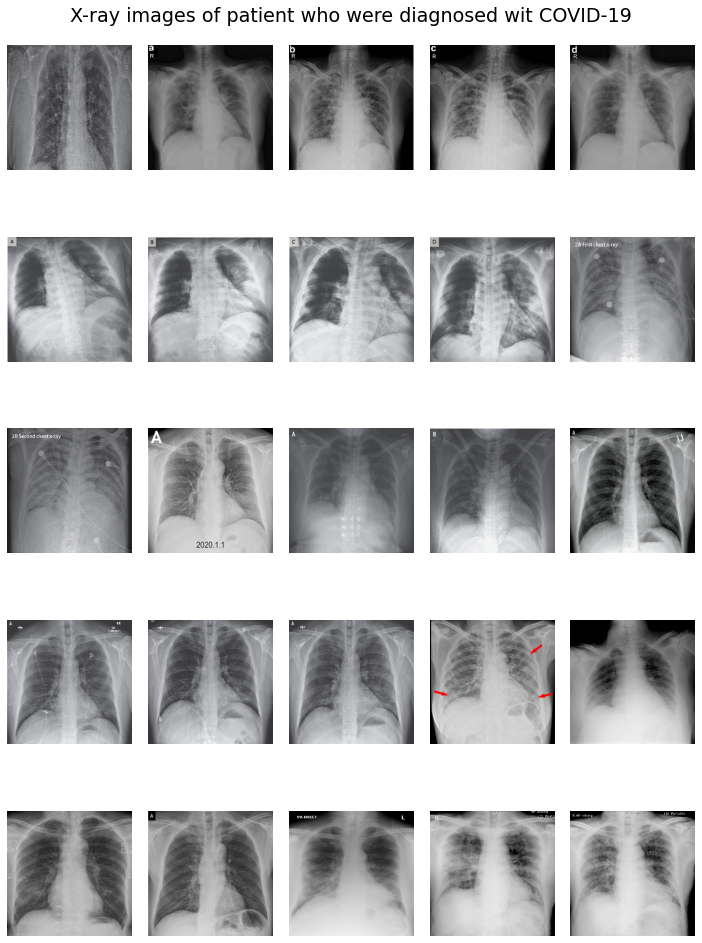

In [63]:
# visulaize images in covid folders
covid_images = glob.glob("dataset/covid/*")
print("Found %i covid images" %len(covid_images))

fig=plt.figure(figsize=(10,14))
plt.rcParams["font.size"]=16
fig.suptitle("X-ray images of patient who were diagnosed wit COVID-19")
cols = 5
rows = 5
fig_list_covid = []

for i in range(cols*rows):
    fig_list_covid.append(fig.add_subplot(rows,cols,i+1))
    img = image_process(covid_images[i])
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

Found 25 covid images


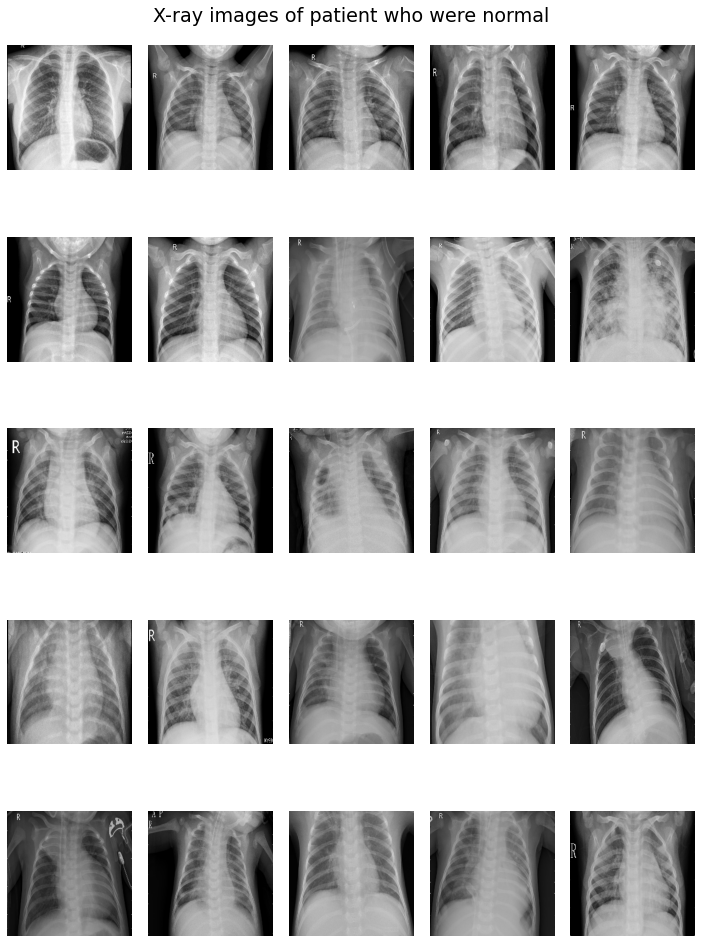

In [64]:
# visulaize images in normal folders
normal_images = glob.glob("dataset/normal/*")
print("Found %i covid images" %len(normal_images))

fig=plt.figure(figsize=(10,14))
plt.rcParams["font.size"]=16
fig.suptitle("X-ray images of patient who were normal")
cols = 5
rows = 5
fig_list_covid = []

for i in range(cols*rows):
    fig_list_covid.append(fig.add_subplot(rows,cols,i+1))
    img = image_process(normal_images[i])
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

In [164]:
# import required libraries and packages
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import *
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Seperate raw data into input X and label y

In [157]:
X = [] # input data
y = [] # labels

for image in np.hstack([covid_images,normal_images]):
    img = image_process(image)
    X.append(img)
    y.append("covid") if "covid" in str(image) else y.append("normal") 
    
X = np.array(X)/255
y = np.array(y)

# convert binary label to one-hot encoding label
lb = LabelBinarizer()
y = lb.fit_transform(y)
y = to_categorical(y)

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Shape of X:  (50, 224, 224, 3)
Shape of y:  (50, 2)


In [267]:
# Split into train set and test set
(X_train,X_test,y_train, y_test) = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print("Train set: X_train %s y_train %s"%(X_train.shape, y_train.shape))
print("Test set: X_test %s y_test %s"%(X_test.shape, y_test.shape))

Train set: X_train (40, 224, 224, 3) y_train (40, 2)
Test set: X_test (10, 224, 224, 3) y_test (10, 2)


In [257]:
# Data augumentation
image_gen = ImageDataGenerator(rotation_range=10, 
                               fill_mode="nearest")

In [268]:
# Load ResNet50V2 network and remove the head layers
ResNet = ResNet50V2(weights="imagenet", include_top = False, input_shape=(224,224,3))

# Free all layers in Resnet to prevent weight updating in those layers
# In this case only the last 4 layers are kept unfree
for layer in ResNet.layers[:-4]:
    layer.trainable = False


In [269]:
# Constructing our model
def create_model(name_model):
    model = Sequential(name=name_model)
    model.add(ResNet)
    model.add(AveragePooling2D(pool_size=(4,4)))
    model.add(Flatten(name="flatten"))
    model.add(Dense(64,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation="softmax"))
    
    return model

model = create_model("Resnet50")
model.summary()

Model: "Resnet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
average_pooling2d_14 (Averag (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_32 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0  

In [270]:
# configurign optimizer, epoch, loss metrics, hyperparameter
epochs = 25
lr = 1e-3
batch_size = 4

opt = Adam(lr=lr,decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# Save weight only if loss is reduced
checkpoint_filepath="covid_detection.h5"
my_checkpointer = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=0),
    ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, save_best_only=True)
                  ]

In [271]:
result = model.fit_generator(image_gen.flow(X_train,y_train,batch_size=batch_size),
                             steps_per_epoch=len(X_train)//batch_size,
                             validation_data=(X_test,y_test),
                             validation_steps=len(X_test)//batch_size,
                             epochs=epochs,callbacks=my_checkpointer)

Epoch 1/25
10/10 [==============================] - 14s 1s/step - loss: 0.7376 - accuracy: 0.5000 - val_loss: 0.7088 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.70884, saving model to covid_detection.h5
Epoch 2/25
10/10 [==============================] - 9s 879ms/step - loss: 0.5348 - accuracy: 0.7750 - val_loss: 1.0041 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.70884
Epoch 3/25
10/10 [==============================] - 9s 918ms/step - loss: 0.2668 - accuracy: 0.9500 - val_loss: 0.5131 - val_accuracy: 0.7000

Epoch 00003: val_loss improved from 0.70884 to 0.51314, saving model to covid_detection.h5
Epoch 4/25
10/10 [==============================] - 9s 935ms/step - loss: 0.2898 - accuracy: 0.8750 - val_loss: 0.1537 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.51314 to 0.15366, saving model to covid_detection.h5
Epoch 5/25
10/10 [==============================] - 9s 937ms/step - loss: 0.1836 - accuracy: 0.8750 - val_loss

In [272]:
# make predictions on the testing set
model.load_weights("covid_detection.h5")
predict = model.predict(X_test,batch_size=batch_size)
predict = np.argmax(predict,axis=1)
predict

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

### Evaluate model

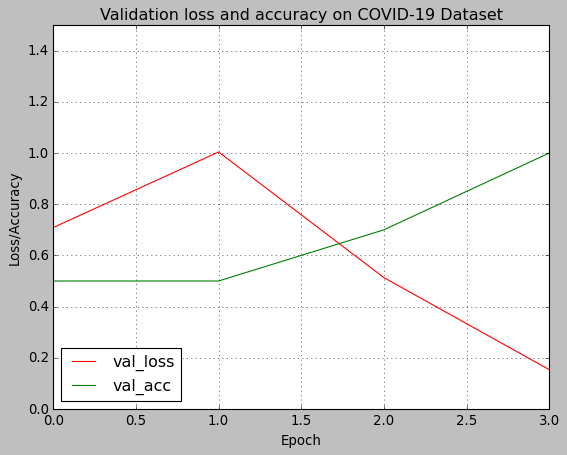

In [278]:
plt.style.use("classic")
plt.figure()
plt.plot(result.history["val_loss"][:4], label="val_loss",color="red")
plt.plot(result.history["val_accuracy"][:4], label="val_acc",color="green")
plt.title("Validation loss and accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.ylim(0,1.5)
plt.xlim(0,3)
plt.legend(loc="lower left")
plt.grid("True")
plt.savefig("traning_result.png",dpi=300)

In [273]:
print(classification_report(np.argmax(y_test,axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.80      0.89         5
      normal       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



### Visualize model's prediction

In [311]:
# declare a function extracting the title from one-hot encoding label
def get_title_from_model(image):
    predict_image = image[np.newaxis,:]
    title = lb.inverse_transform(model.predict(predict_image))
    return title[0]

'normal'

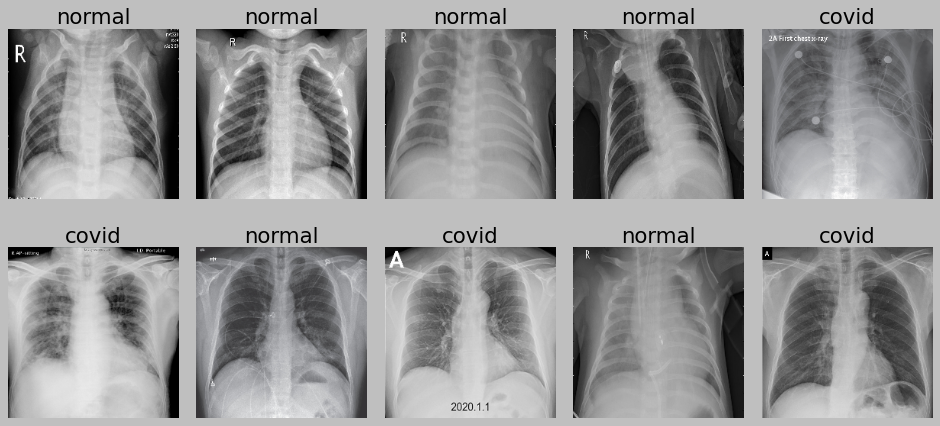

In [331]:
# Display multiple prediction with the model

fig = plt.figure(figsize=(12,6))
plt.rcParams["font.size"]=16
cols = 5
rows = 2

fig_list=[]


for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    fig_list[-1].set_title(get_title_from_model(X_test[i]))
    plt.axis(False)
    plt.imshow(X_test[i])

plt.tight_layout(True)
plt.savefig("covid_prediction.png",dpi=300)
plt.show()

### Summary

In this project, we have created a model which has the accuracy of 90% to predict Coronal symptom from X-ray images. However, it should be noticed that this model was trained with only 50 images, which are far less than a typical deep learning dataset (thoudsands of images). Overfitting is also existed in training graph. For this reason, **it is not reliable to claim that the result reflect accurately all covid predictions from X-ray images!**